# *Tutorial: Tree Dataframes*

**Author:** [Eivind Tøstesen](https://github.com/eivindtostesen)

**Tutorial goal:** *How to organize results from peak analysis in dataframes using an interface to pandas or polars.*

## Introduction

*The results of a hierarchical analysis of peaks in 1D data are organized in a `Tree` object.
It can always be printed (str and repr),
but a better way of viewing, exploring and transforming the results is to export them to dataframes.*

*This notebook demonstrates the dataframe functionality provided by `interface_pandas` and `interface_polars`, which equip  `Tree` objects with new methods built on pandas/polars, and gives some example recipes.*

## Imports
The optional modules `interface_pandas` and `interface_polars` have almost identical methods and APIs, and each one is sufficient for doing dataframes, but we will demonstrate both.

In [15]:
from matplotlib.pyplot import plot
from pandas import concat

import peakoscope

# In this notebook, we import both, but you can choose to import only one:
import peakoscope.interface_pandas  # requires pandas
import peakoscope.interface_polars  # requires polars

# We also document our random seed value: 
RANDOM_SEED = "it's....."

## Example data set
Throughout the notebook, we will use the same mini example for our data set. It consists of two lists: `X` (labels) and `Y` (values). The data types are str and float, respectively.



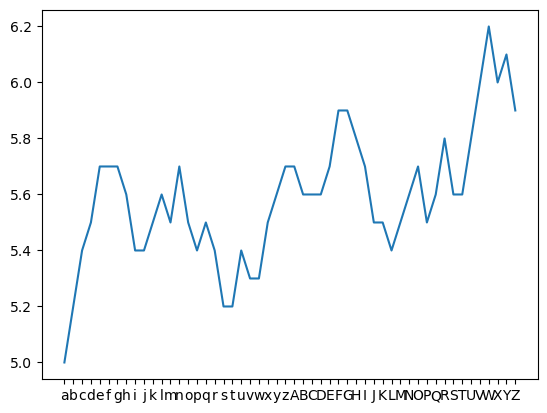

In [16]:
# Generate the data set:
X, Y = peakoscope.example_1(randomseed=RANDOM_SEED)

# Plot the data set:
plot(X, Y);

## Peak analysis
The peak regions in the data `X,Y` are analysed by calling `peakoscope.tree(Y)`. This function returns a `Tree` object, in which the tree nodes are objects of the `Scope` class. A `Scope` represents a peak and is written in the slice notation (start:stop), which specifies the peak region.

In [17]:
# Generate the data set:
X, Y = peakoscope.example_1(randomseed=RANDOM_SEED)

# Get the peak analysis results:
peaks = peakoscope.tree(Y)

# print the tree of peaks:
print(peaks)

0:52
└─1:52
  ├─20:52
  │ ├─23:52
  │ │ ├─38:52
  │ │ │ ├─42:52
  │ │ │ │ ├─46:52
  │ │ │ │ │ └─47:52
  │ │ │ │ │   └─47:51
  │ │ │ │ │     ├─48:49
  │ │ │ │ │     └─50:51
  │ │ │ │ └─43:44
  │ │ │ └─38:41
  │ │ │   └─39:41
  │ │ │     └─40:41
  │ │ └─23:37
  │ │   └─24:35
  │ │     ├─30:35
  │ │     │ └─31:35
  │ │     │   └─31:34
  │ │     │     └─31:33
  │ │     └─25:27
  │ └─20:21
  └─2:18
    ├─3:8
    │ └─4:8
    │   └─4:7
    ├─10:15
    │ ├─13:14
    │ └─11:12
    └─16:17


Dataframe functionality is then initialized by calling the `TreePolars` class. This will give the `peaks` an attribute called "polars".


In [18]:
# Generate the data set:
X, Y = peakoscope.example_1(randomseed=RANDOM_SEED)
# Get the peak analysis results:
peaks = peakoscope.tree(Y)

# Add polars functionality to the peaks:
peakoscope.interface_polars.TreePolars(peaks, attrname="polars", X=X)

# The new attribute:
peaks.polars

The `peaks` can be exported to a series or a one-column dataframe by calling the methods `peaks.polars.series` or `peaks.polars.dataframe` with no arguments:

In [19]:
# Generate the data set:
X, Y = peakoscope.example_1(randomseed=RANDOM_SEED)
# Get the peak analysis results:
peaks = peakoscope.tree(Y)
# Add polars functionality to the peaks:
peakoscope.interface_polars.TreePolars(peaks, attrname="polars", X=X)

# A polars series containing all peak regions:
peaks.polars.series()

node
object
0:52
1:52
20:52
23:52
38:52
…
25:27
10:15
13:14


The method `peaks.polars.location_properties` returns a dataframe with columns for the start and end positions on the x-axis of each peak region. It also has a column called location that combines start and end. These start and ends are both included in the peak region, because they are label-based, while the node is displayed in slice notation, which is integer-based and does not include the stop value.

In [20]:
# Generate the data set:
X, Y = peakoscope.example_1(randomseed=RANDOM_SEED)
# Get the peak analysis results:
peaks = peakoscope.tree(Y)
# Add polars functionality to the peaks:
peakoscope.interface_polars.TreePolars(peaks, attrname="polars", X=X)

# Dataframe with peak spans on the x-axis:
peaks.polars.location_properties()

node,location,x_start,x_end
object,str,str,str
0:52,"""a..Z""","""a""","""Z"""
1:52,"""b..Z""","""b""","""Z"""
20:52,"""u..Z""","""u""","""Z"""
23:52,"""x..Z""","""x""","""Z"""
38:52,"""M..Z""","""M""","""Z"""
…,…,…,…
25:27,"""z..A""","""z""","""A"""
10:15,"""k..o""","""k""","""o"""
13:14,"""n..n""","""n""","""n"""


The method `peaks.polars.tree_structure` returns a dataframe containing each tree node and its parent node, its children nodes, etcetera, showing the network structure of the tree. 

Each node is looked up in the "node" column, which is the key column, and other columns then show the corresponding:
- parent node
- children nodes
- tip node (the smallest region having the same maximum)
- full node (the largest region having the same maximum)

For better readability, the dataframe rows are ordered according to paths from tip nodes to full nodes. The node that has None as parent is the root and it spans the whole data array.

In [21]:
# Generate the data set:
X, Y = peakoscope.example_1(randomseed=RANDOM_SEED)
# Get the peak analysis results:
peaks = peakoscope.tree(Y)
# Add polars functionality to the peaks:
peakoscope.interface_polars.TreePolars(peaks, attrname="polars", X=X)

# Dataframe with the network of peak nodes:
peaks.polars.tree_structure()

tip,children,node,parent,full,root
object,list[str],object,object,object,object
48:49,[],48:49,47:51,0:52,0:52
48:49,"[""48:49"", ""50:51""]",47:51,47:52,0:52,0:52
48:49,"[""47:51""]",47:52,46:52,0:52,0:52
48:49,"[""47:52""]",46:52,42:52,0:52,0:52
48:49,"[""46:52"", ""43:44""]",42:52,38:52,0:52,0:52
…,…,…,…,…,…
4:7,"[""3:8"", ""10:15"", ""16:17""]",2:18,1:52,2:18,0:52
13:14,[],13:14,10:15,10:15,0:52
13:14,"[""13:14"", ""11:12""]",10:15,2:18,10:15,0:52


The `peaks.polars.numeric_properties` method returns a dataframe containing each node's size, max and min values. Rows are ordered by descending max and size.

In [22]:
# Generate the data set:
X, Y = peakoscope.example_1(randomseed=RANDOM_SEED)
# Get the peak analysis results:
peaks = peakoscope.tree(Y)
# Add polars functionality to the peaks:
peakoscope.interface_polars.TreePolars(peaks, attrname="polars", X=X)

# Dataframe with peak spans on the y-axis:
peaks.polars.numeric_properties()

node,max,size,min
object,f64,f64,f64
0:52,6.2,1.2,5.0
1:52,6.2,1.0,5.2
20:52,6.2,0.9,5.3
23:52,6.2,0.8,5.4
38:52,6.2,0.7,5.5
…,…,…,…
25:27,5.7,0.0,5.7
13:14,5.7,0.0,5.7
11:12,5.6,0.0,5.6


## Basic pandas functionality
We could repeat the previous section on "Basic polars functionality", replacing "polars" with "pandas" everywhere, and it would show the same output.

To make it less repetitive, we show how to concatenate the three dataframes into a one-view dataframe. The dataframes to be concatenated are:
- `peaks.pandas.location_properties()`
- `peaks.pandas.tree_structure()`
- `peaks.pandas.numeric_properties()`

Rows need to be sorted in the same order, but `peaks.pandas` has a `sort` method with a default order, that we can pipe each dataframe to.

In [23]:
# Generate the data set:
X, Y = peakoscope.example_1(randomseed=RANDOM_SEED)
# Get the peak analysis results:
peaks = peakoscope.tree(Y)
# Add pandas functionality to the peaks:
peakoscope.interface_pandas.TreePandas(peaks, attrname="pandas", X=X)

# Let pandas concatenate the sorted dataframes under a hierarchical index:
concat(
    {
        "Location Props": peaks.pandas.location_properties().pipe(peaks.pandas.sort),
        "Tree Structure": peaks.pandas.tree_structure().pipe(peaks.pandas.sort),
        "Numeric Props": peaks.pandas.numeric_properties().pipe(peaks.pandas.sort),
    },
    axis=1,
)

Location Props                        Tree Structure                       \
             node location x_start x_end            tip             children   
0            0:52     a..Z       a     Z          48:49               [1:52]   
1            1:52     b..Z       b     Z          48:49        [20:52, 2:18]   
2           20:52     u..Z       u     Z          48:49       [23:52, 20:21]   
3           23:52     x..Z       x     Z          48:49       [38:52, 23:37]   
4           38:52     M..Z       M     Z          48:49       [42:52, 38:41]   
5           42:52     Q..Z       Q     Z          48:49       [46:52, 43:44]   
6           46:52     U..Z       U     Z          48:49              [47:52]   
7           47:52     V..Z       V     Z          48:49              [47:51]   
8           47:51     V..Y       V     Y          48:49       [48:49, 50:51]   
9           48:49     W..W       W     W          48:49                   []   
10           2:18     c..r       c     r            4:7  [3:8, 10:15, 16:17]   
11            3:8     d..h       d     h            4:7                [4:8]   
12            4:8     e..h       e     h            4:7                [4:7]   
13            4:7     e..g       e     g            4:7                   []   
14          20:21     u..u       u     u          20:21                   []   
15          23:37     x..K       x     K          31:33              [24:35]   
16          24:35     y..I       y     I          31:33       [30:35, 25:27]   
17          30:35     E..I       E     I          31:33              [31:35]   
18          31:35     F..I       F     I          31:33              [31:34]   
19          31:34     F..H       F     H          31:33              [31:33]   
20          31:33     F..G       F     G          31:33                   []   
21          38:41     M..O       M     O          40:41              [39:41]   
22          39:41     N..O       N     O          40:41              [40:41]   
23          40:41     O..O       O     O          40:41                   []   
24          43:44     R..R       R     R          43:44                   []   
25          50:51     Y..Y       Y     Y          50:51                   []   
26          25:27     z..A       z     A          25:27                   []   
27          10:15     k..o       k     o          13:14       [13:14, 11:12]   
28          13:14     n..n       n     n          13:14                   []   
29          16:17     q..q       q     q          16:17                   []   
30          11:12     l..l       l     l          11:12                   []   

                              Numeric Props                 
     node parent   full  root          node  max size  min  
0    0:52   None   0:52  0:52          0:52  6.2  1.2  5.0  
1    1:52   0:52   0:52  0:52          1:52  6.2  1.0  5.2  
2   20:52   1:52   0:52  0:52         20:52  6.2  0.9  5.3  
3   23:52  20:52   0:52  0:52         23:52  6.2  0.8  5.4  
4   38:52  23:52   0:52  0:52         38:52  6.2  0.7  5.5  
5   42:52  38:52   0:52  0:52         42:52  6.2  0.6  5.6  
6   46:52  42:52   0:52  0:52         46:52  6.2  0.4  5.8  
7   47:52  46:52   0:52  0:52         47:52  6.2  0.3  5.9  
8   47:51  47:52   0:52  0:52         47:51  6.2  0.2  6.0  
9   48:49  47:51   0:52  0:52         48:49  6.2  0.0  6.2  
10   2:18   1:52   2:18  0:52          2:18  5.7  0.3  5.4  
11    3:8   2:18   2:18  0:52           3:8  5.7  0.2  5.5  
12    4:8    3:8   2:18  0:52           4:8  5.7  0.1  5.6  
13    4:7    4:8   2:18  0:52           4:7  5.7  0.0  5.7  
14  20:21  20:52  20:21  0:52         20:21  5.4  0.0  5.4  
15  23:37  23:52  23:37  0:52         23:37  5.9  0.4  5.5  
16  24:35  23:37  23:37  0:52         24:35  5.9  0.3  5.6  
17  30:35  24:35  23:37  0:52         30:35  5.9  0.2  5.7  
18  31:35  30:35  23:37  0:52         31:35  5.9  0.2  5.7  
19  31:34  31:35  23:37  0:52         31:34  5.9  0.1  5.8  
20  31:33  31:34  23

Notes:
- The same node column appear three places. Just more readable?
- The integer index on the left can be ignored, since it is not meaningful. This is true for all `tree.pandas` dataframes.



## Viewing internal data attributes
The internal data structure of a `Tree` object can also be exported. This can be useful for inspection or storage.

First in polars:

In [24]:
# Generate the data set:
X, Y = peakoscope.example_1(randomseed=RANDOM_SEED)
# Get the peak analysis results:
peaks = peakoscope.tree(Y)
# Add polars functionality to the peaks:
peakoscope.interface_polars.TreePolars(peaks, attrname="polars", X=X)

# Export Tree data:
peaks.polars.dump_data_attributes()


node,_parent,_children,_tip,_full,_root
object,str,list[str],str,str,str
0:52,null,"[""1:52""]","""48:49""","""0:52""","""0:52"""
1:52,"""0:52""","[""20:52"", ""2:18""]","""48:49""","""0:52""","""0:52"""
20:52,"""1:52""","[""23:52"", ""20:21""]","""48:49""","""0:52""","""0:52"""
23:52,"""20:52""","[""38:52"", ""23:37""]","""48:49""","""0:52""","""0:52"""
38:52,"""23:52""","[""42:52"", ""38:41""]","""48:49""","""0:52""","""0:52"""
…,…,…,…,…,…
25:27,"""24:35""",[],"""25:27""","""25:27""","""0:52"""
10:15,"""2:18""","[""13:14"", ""11:12""]","""13:14""","""10:15""","""0:52"""
13:14,"""10:15""",[],"""13:14""","""10:15""","""0:52"""


And in pandas:

In [25]:
# Generate the data set:
X, Y = peakoscope.example_1(randomseed=RANDOM_SEED)
# Get the peak analysis results:
peaks = peakoscope.tree(Y)
# Add pandas functionality to the peaks:
peakoscope.interface_pandas.TreePandas(peaks, attrname="pandas", X=X)

# Export Tree data:
peaks.pandas.dump_data_attributes()


,node,_parent,_children,_tip,_full,_root
0,0:52,<NA>,"(1:52,)",48:49,0:52,0:52
1,1:52,0:52,"(20:52, 2:18)",48:49,0:52,0:52
2,20:52,1:52,"(23:52, 20:21)",48:49,0:52,0:52
3,23:52,20:52,"(38:52, 23:37)",48:49,0:52,0:52
4,38:52,23:52,"(42:52, 38:41)",48:49,0:52,0:52
5,42:52,38:52,"(46:52, 43:44)",48:49,0:52,0:52
6,46:52,42:52,"(47:52,)",48:49,0:52,0:52
7,47:52,46:52,"(47:51,)",48:49,0:52,0:52
8,47:51,47:52,"(48:49, 50:51)",48:49,0:52,0:52
9,48:49,47:51,(),48:49,0:52,0:52
